# Wavelets for EEG Denoising Under tES

In [2]:
import pywt, math
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from typing import Any
from tqdm import tqdm
from benchmark_metrics import *

def load_data(folder_path: str) -> dict[str, dict[str, NDArray[np.float32]]]:
    dataset = {}
    for split in ['train', 'val', 'test']:
        dataset[split] = {}
        dataset[split]['denoised'] = np.load(folder_path + f'Denoiseoutput_{split}.npy')
        dataset[split]['ground_truth'] = np.load(folder_path + f'EEG_{split}.npy')
        dataset[split]['noisy_input'] = np.load(folder_path + f'noiseinput_{split}.npy')
    print('Finished Loading EEG Data!')
    return dataset

## 1. Visual Example of Wavelet Denoising

In [4]:
data = load_data('data/tDCS/')

Finished Loading EEG Data!


In [5]:
def wavelet_denoise(signal, wavelet_type = 'sym4', threshold = 0.05):
    coeffs = pywt.wavedec(signal, wavelet_type, level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet(wavelet_type).dec_len))
    coeffs = [pywt.threshold(coeff, threshold * max(coeff)) for coeff in coeffs]
    #for i in range(1, len(coeffs)):
    #    lambda_val = math.sqrt(2*math.log(len(coeffs[i]))) # Threshold for filtering, SureShrink method
    #    coeffs[i] = pywt.threshold(coeffs[i], lambda_val, 'soft') # Filter the noise using a soft decision
    return pywt.waverec(coeffs, wavelet_type)

reconstructed_signal = wavelet_denoise(data['test']['noisy_input'][0])
print(f'Finished Running Wavelet Denoising -> Shape: {reconstructed_signal.shape}')

Finished Running Wavelet Denoising -> Shape: (512,)


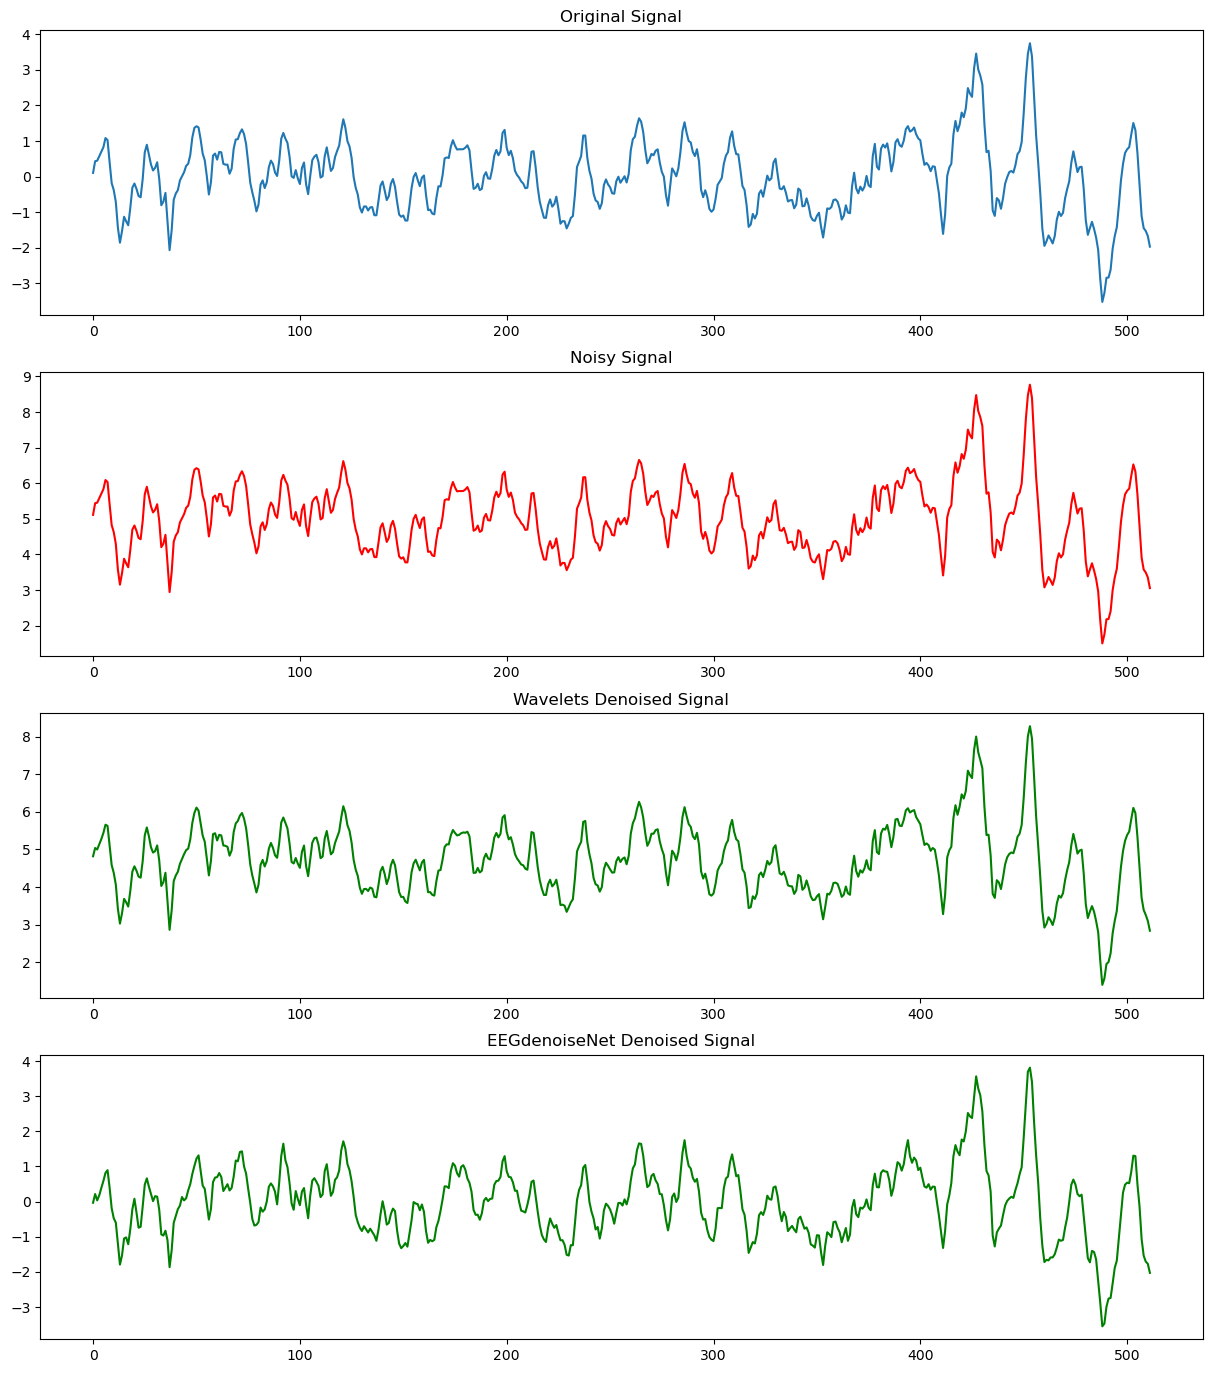

In [4]:
f, ax = plt.subplots(4, 1, figsize = (15, 17))
ax[0].plot(data['test']['ground_truth'][0]), ax[0].title.set_text("Original Signal")
ax[1].plot(data['test']['noisy_input'][0], color = 'red'), ax[1].title.set_text("Noisy Signal")
ax[2].plot(reconstructed_signal, color = 'green'), ax[2].title.set_text("Wavelets Denoised Signal")
ax[3].plot(data['test']['denoised'][0], color = 'green'), ax[3].title.set_text("EEGdenoiseNet Denoised Signal")
plt.show()

In [5]:
print(f"Correlation Coefficient (CC) for the example above: {cc(reconstructed_signal, data['test']['ground_truth'][0]):.2f}")

Correlation Coefficient (CC) for the example above: 1.00


## 2. Denoising All Samples

In [6]:
data = load_data('data/tDCS/') # Can either be tDCS/tRNS/tACS

Finished Loading EEG Data!


In [7]:
print('Applying Wavelet Denoising to Test Set...')
metrics = {k:[] for k in ['rrmse_temporal', 'rrmse_spectral', 'cc']}
for signal in tqdm(range(data['test']['noisy_input'].shape[0])):
    ground_truth, noisy_input = data['test']['ground_truth'][signal], data['test']['noisy_input'][signal]
    denoised_signal = wavelet_denoise(noisy_input)
    metrics['rrmse_temporal'].append(rrmse_temporal(denoised_signal, ground_truth))
    metrics['rrmse_spectral'].append(rrmse_spectral(denoised_signal, ground_truth))
    metrics['cc'].append(cc(denoised_signal, ground_truth))
print('Finished Denoising Process!')
avg_metrics = {k: np.mean(v) for k,v in metrics.items()}
print('Average Metrics:', avg_metrics)

Applying Wavelet Denoising to Test Set...


100%|███████████████████████████████████████████████████████████████████████████████████████| 4510/4510 [00:03<00:00, 1220.21it/s]

Finished Denoising Process!
Average Metrics: {'rrmse_temporal': 2.037343067095183, 'rrmse_spectral': 0.1426866604065442, 'cc': 0.9991896572420957}


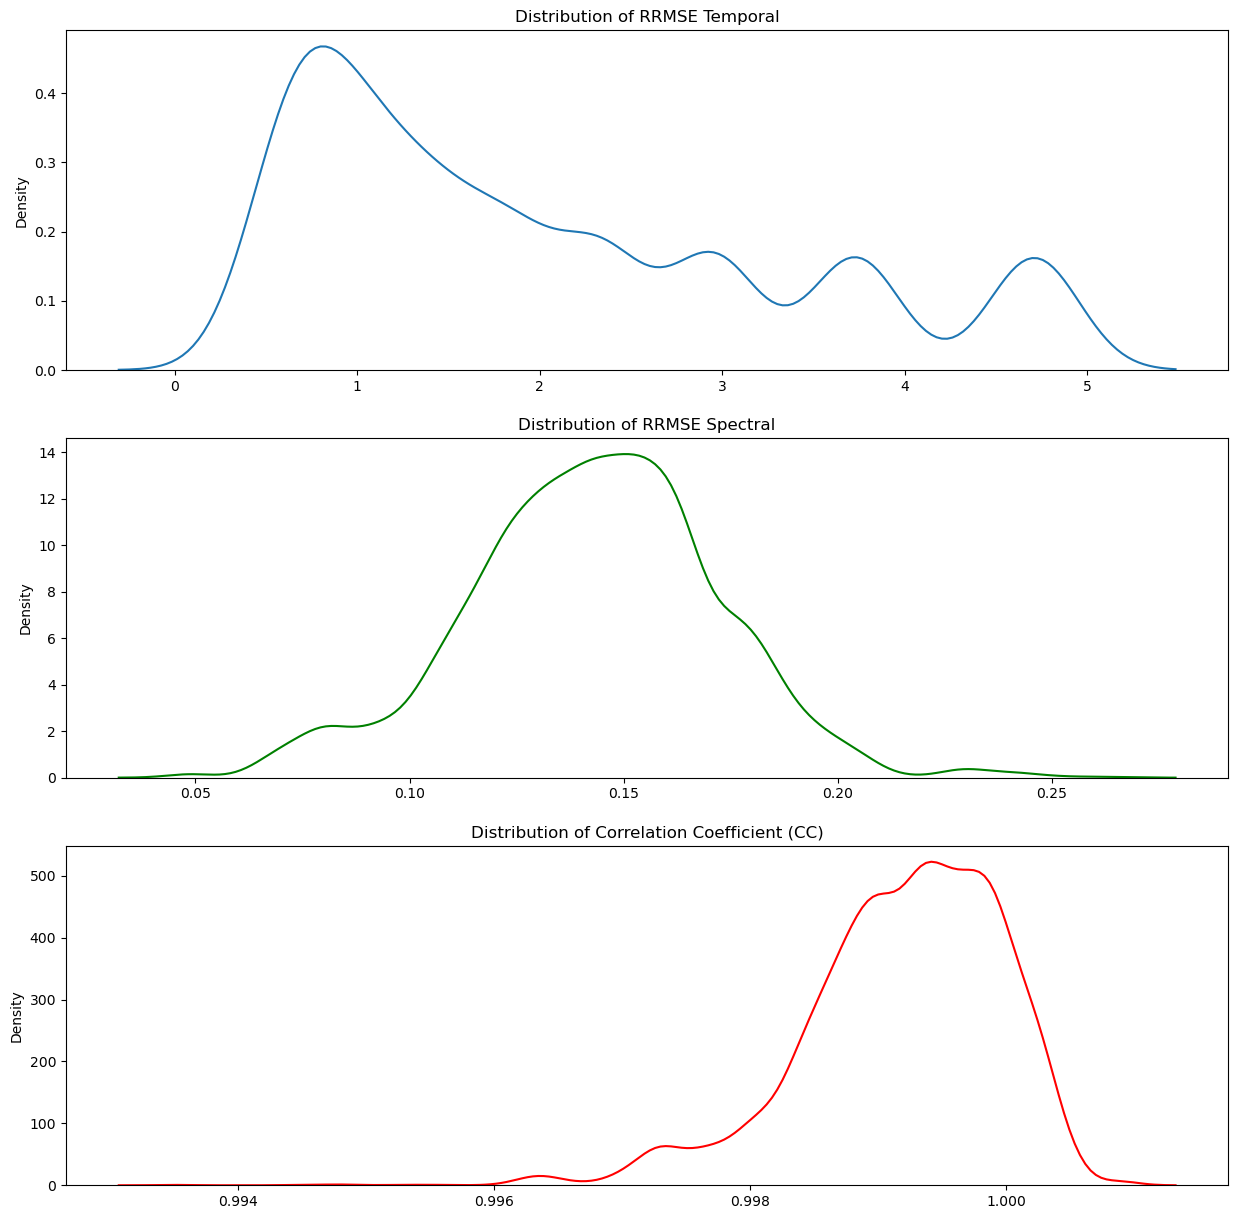

In [8]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

f, ax = plt.subplots(3, 1, figsize = (15, 15))
sns.kdeplot(metrics['rrmse_temporal'], ax = ax[0]), ax[0].title.set_text("Distribution of RRMSE Temporal")
sns.kdeplot(metrics['rrmse_spectral'], ax = ax[1], color = 'green'), ax[1].title.set_text("Distribution of RRMSE Spectral")
sns.kdeplot(metrics['cc'], ax = ax[2], color = 'red'), ax[2].title.set_text("Distribution of Correlation Coefficient (CC)")
plt.show()

## 3. Training a Model using Wavelet Decomposition as Features

In [6]:
from scipy.stats import entropy as shanon_entropy
from collections import Counter

def calculate_entropy(dwt_coeff):
    counter_values = Counter(dwt_coeff).most_common()
    probabilities = [elem[1]/len(dwt_coeff) for elem in counter_values]
    return shanon_entropy(probabilities)
   
def get_features(dwt_coeff):
    entropy = calculate_entropy(dwt_coeff)
    statistics = [np.mean(dwt_coeff), np.median(dwt_coeff), np.std(dwt_coeff), np.sqrt(np.mean(dwt_coeff ** 2))]
    return [entropy] + statistics

def wavelet_construct_features(signal, wavelet_type = 'sym4'):
    coeffs = pywt.wavedec(signal, wavelet_type, level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet(wavelet_type).dec_len))
    #features = []
    #for coeff in coeffs:
    #    features += get_features(coeff)
    #return features
    return np.concatenate(coeffs)

In [12]:
import xgboost
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Load Data
data = load_data('data/tDCS/') # Can either be tDCS/tRNS/tACS

Finished Loading EEG Data!


In [13]:
print("Preparing Training Data for Model...")
X_train, y_train = [], []
for signal in tqdm(range(data['train']['noisy_input'].shape[0])):
    ground_truth, noisy_input = data['train']['ground_truth'][signal], data['train']['noisy_input'][signal]
    features = wavelet_construct_features(noisy_input)
    X_train.append(features)
    y_train.append(ground_truth)

print("Training Denoising Model with Wavelet Features...")
model.fit(X_train, y_train)

print('Applying Denoising to Test Set...')
metrics = {k:[] for k in ['rrmse_temporal', 'rrmse_spectral', 'cc']}
for signal in tqdm(range(data['test']['noisy_input'].shape[0])):
    ground_truth, noisy_input = data['test']['ground_truth'][signal], data['test']['noisy_input'][signal]
    features = wavelet_construct_features(noisy_input)
    denoised_signal = model.predict([features])
    metrics['rrmse_temporal'].append(rrmse_temporal(denoised_signal, ground_truth))
    metrics['rrmse_spectral'].append(rrmse_spectral(denoised_signal, ground_truth))
    metrics['cc'].append(cc(denoised_signal, ground_truth))
print('Finished Denoising Process!')
avg_metrics = {k: np.mean(v) for k,v in metrics.items()}
print('Average Metrics:', avg_metrics)

Preparing Training Data for Model...


100%|████████████████████████████████████████████████████████████████████████████████████| 36110/36110 [00:02<00:00, 16272.74it/s]


Training Denoising Model with Wavelet Features...
Applying Denoising to Test Set...


100%|███████████████████████████████████████████████████████████████████████████████████████| 4510/4510 [00:03<00:00, 1173.96it/s]

Finished Denoising Process!
Average Metrics: {'rrmse_temporal': 0.07171457005550275, 'rrmse_spectral': 0.006336158898442011, 'cc': 1.0019558995758955}


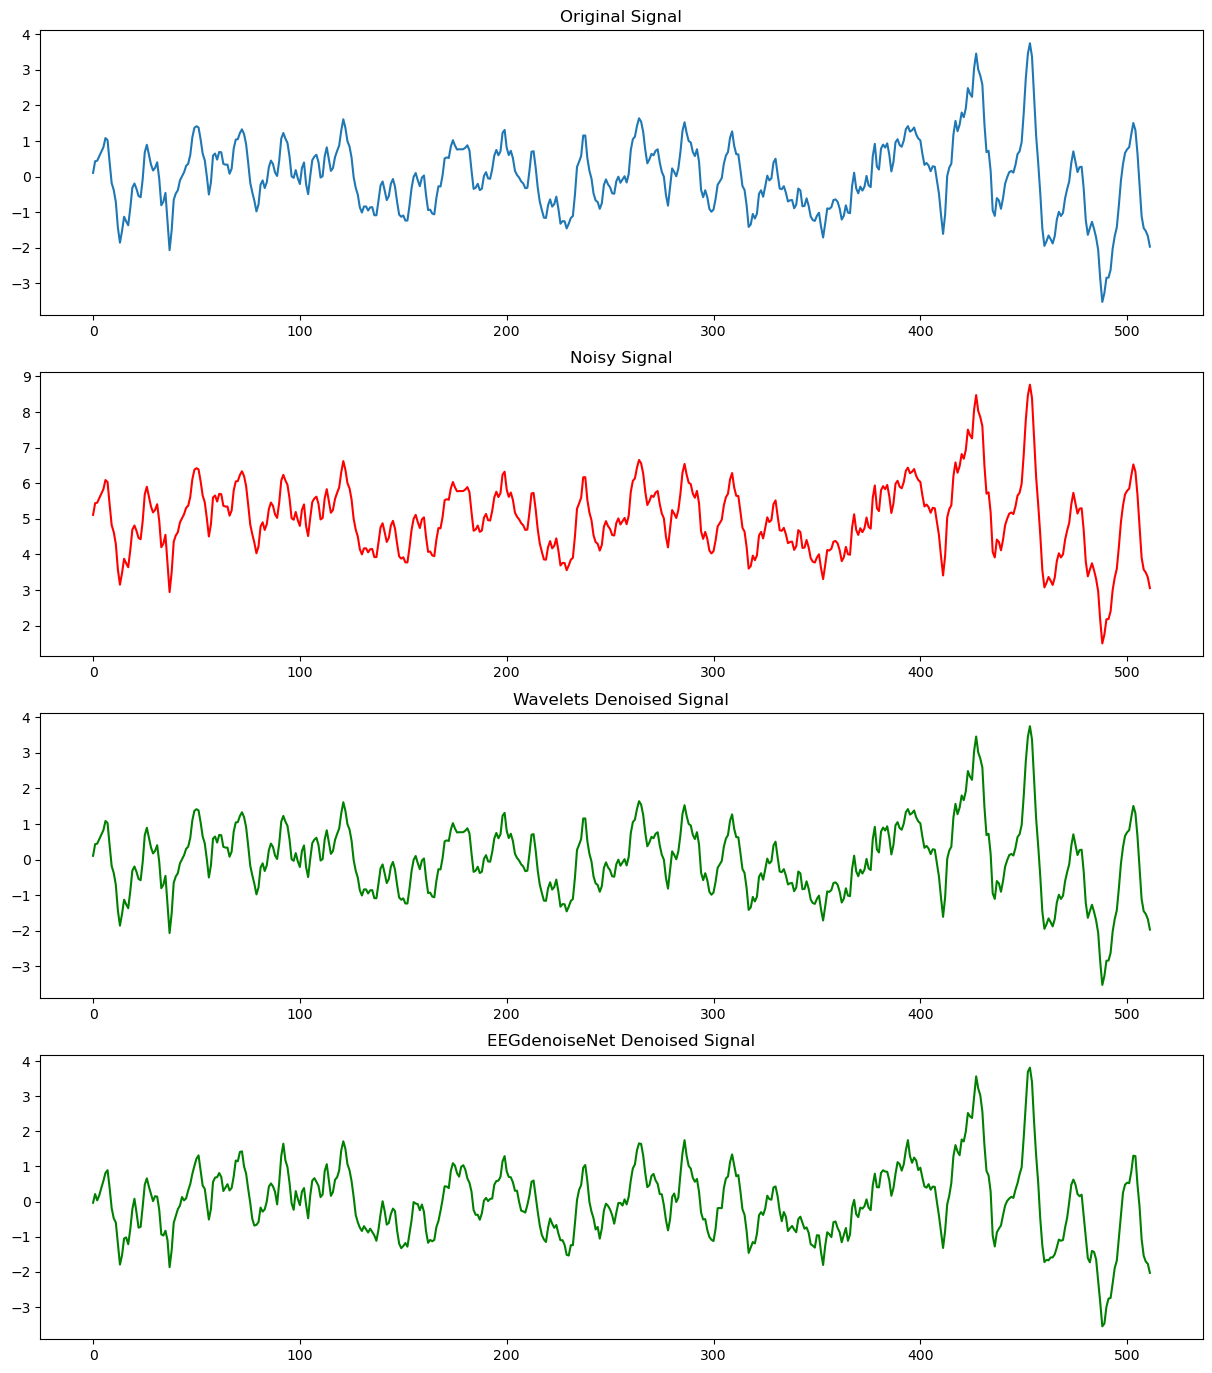

In [46]:
f, ax = plt.subplots(4, 1, figsize = (15, 17))
ax[0].plot(data['test']['ground_truth'][0]), ax[0].title.set_text("Original Signal")
ax[1].plot(data['test']['noisy_input'][0], color = 'red'), ax[1].title.set_text("Noisy Signal")
ax[2].plot(model.predict([wavelet_construct_features(data['test']['noisy_input'][0])]).reshape(512, 1), color = 'green'), ax[2].title.set_text("Wavelets Denoised Signal")
ax[3].plot(data['test']['denoised'][0], color = 'green'), ax[3].title.set_text("EEGdenoiseNet Denoised Signal")
plt.show()